# <b style="color:blue">Deep Learning Project- Gesture Recognition</b>

## Project Members
### 	Kuldeep Pawar
### 	Kuldeep Pawar


# <b style="color:red"> Problem statement</b>

> As a data scientist at a home electronics company which manufactures state of the art smart televisions. We want to develop a cool feature in the smart-TV that can recognize five different gestures performed by the user which will help users control the TV without using a remote. 

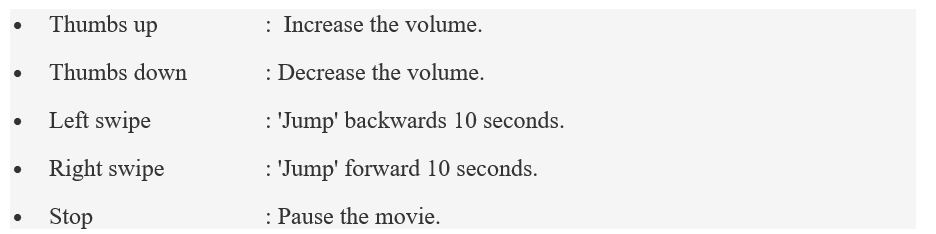

# <b style="color:red"> Understanding the Dataset</b>

> Data Source : https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL

> The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

# <b style="color:red"> Objective </b>

> Our task is to train different models on the 'train' folder to predict the action performed in each sequence or video and which performs well on the 'val' folder as well. The final test folder for evaluation is withheld - final model's performance will be tested on the 'test' set.

# <b style="color:red"> Two Architectures: 3D Conv and CNN-RNN Stack </b>

> 1.	CNN + RNN architecture 
>> The conv2D network will extract a feature vector for each image, and a sequence of these feature vectors is then fed to an RNN-based network. The output of the RNN is a regular softmax.

> 2.	3D Convolutional Neural Networks (Conv3D)
>> In this case, the input to a 3D conv is a video (which is a sequence of 30 RGB images). If we assume that the shape of each image is 100 x 100 x 3, for example, the video becomes a 4D tensor of shape 100 x 100 x 3 x 30 which can be written as (100 x 100 x 30) x 3 where 3 is the number of channels. Hence, deriving the analogy from 2D convolutions where a 2D kernel/filter (a square filter) is represented as (f x f) x c where f is filter size and c is the number of channels, a 3D kernel/filter (a 'cubic' filter) is represented as (f x f x f) x c (here c = 3 since the input images have three channels). This cubic filter will now '3D-convolve' on each of the three channels of the (100 x 100 x 30) tensor

In [1]:
# load library
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

>We set the random seed so that the results don't vary drastically each run of the files.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines()) #train data details
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())     #validation data details
batch_size = 15                                                                              #started with lower batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

>Data Processing:

>>•	Deciding on number of images to be taken per video/sequence

>>•	Resizing  and cropping the images : This was mainly done to ensure that the Neural network only recognizes the gestures effectively rather than focusing on the other background noise present in the image. We used 120 by 120 image size after experimenting with different sizes.

>>•	Normalizing the images : Normalizing the RGB values of an image can at times be a simple and effective way to get rid of distortions caused by lights and shadows in an image.


In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,30,2)]#create a list of image numbers you want to use for a particular video, we are not using all the 30 images in a video, selected pickup of images
    while True:
        t = np.random.permutation(folder_list)
        num_batches =int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx)
            y=120
            z=120
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            cnt_img=0
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    norm_image=image/255.0
                    image_resized=resize(norm_image,(120,120),mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        cnt_img=0
        batch_cover = num_batches*batch_size
        rem = len(t) - batch_cover
        if(len(t)!=batch_cover):
            for folder in range(rem):
                imgs = os.listdir(source_path+'/'+ t[folder + batch_cover].split(';')[0]) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + batch_cover].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    norm_image = image/255.0 # normalizing the image 
                    image_resized=resize(norm_image, (120,120), mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + batch_size].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, TimeDistributed,Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from keras.layers.convolutional import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from keras.regularizers import l2

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
def train_model( model):
        # Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
        train_generator = generator(train_path, train_doc, batch_size)
        val_generator = generator(val_path, val_doc, batch_size)

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/' #file name
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' #file path

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1) #chekpoints to save model in .h5
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001) #learning Rate
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches
            
        # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


In [8]:
# plot accuracy & loss graph for training & validation results
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [9]:
def plot_2(history):
    plt.plot(trained_model.history['categorical_accuracy'])
    plt.plot(trained_model.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Model 1 : Conv2D layers + GRU Layer+ Adam optimiser + No dropout

In [10]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15


# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu'))
model.add(Dense(num_denselayers[1], activation='relu'))

## using GRU as the RNN model
model.add(GRU(64, return_sequences=False))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

2022-05-17 02:21:45.096311: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-17 02:21:45.096387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [11]:
from tensorflow.keras.optimizers import Adam
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 60, 60, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 60, 60, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 30, 30, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 30, 30, 32)   1

In [12]:
print("Total Params:", model.count_params())
trained_model_1=train_model(model)

Total Params: 152453
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_470/626052411.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20


2022-05-17 02:21:49.732991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 1.2102 - categorical_accuracy: 0.5007Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.72273, saving model to model_init_2022-05-1702_21_43.511214/model-00001-1.21024-0.50074-1.72273-0.26667.h5
45/45 [==============================] - 86s 2s/step - loss: 1.2102 - categorical_accuracy: 0.5007 - val_loss: 1.7227 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.7949 - categorical_accuracy: 0.7096
Epoch 00002: val_loss did not improve from 1.72273
45/45 [==============================] - 82s 2s/step - loss: 0.7949 - categorical_accuracy: 0.7096 - val_loss: 2.3497 - val_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.5332 - categorical_accuracy: 0.7926
Epoch 00003: val_loss did not improve from 1.72273
45/45 [==============================] - 8

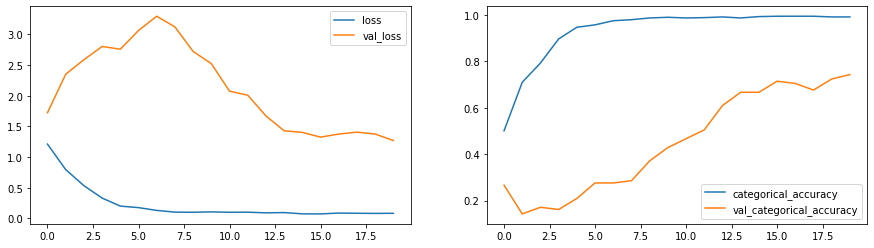

In [13]:
plot(trained_model_1)

Observation

- The accuracy on the training dataset in very high while the accuracy on the validation dataset is too less.
- This is an indication of overfitting on the training dataset.

### Model 2 : Conv2D layers + GRU Layer+ Adam optimiser + Dropout

In [14]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout=0.25


# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu'))
model.add(Dense(num_denselayers[1], activation='relu'))
model.add(Dropout(dropout))

## using GRU as the RNN model
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

In [15]:
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 dropout (Dropout)           (None, 15, 30, 30, 16)    0         
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 30, 30, 32)   4640      
 stributed)                                           

In [16]:
print("Total Params:", model.count_params())
trained_model_2=train_model(model)

Total Params: 152453
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_470/626052411.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.4235 - categorical_accuracy: 0.3674Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.93085, saving model to model_init_2022-05-1702_21_43.511214/model-00001-1.42349-0.36741-1.93085-0.22857.h5
45/45 [==============================] - 81s 2s/step - loss: 1.4235 - categorical_accuracy: 0.3674 - val_loss: 1.9309 - val_categorical_accuracy: 0.2286 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 1.1263 - categorical_accuracy: 0.5289
Epoch 00002: val_loss did not improve from 1.93085
45/45 [==============================] - 81s 2s/step - loss: 1.1263 - categorical_accuracy: 0.5289 - val_loss: 2.4364 - val_categorical_accuracy: 0.2190 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.8726 - categorical_accuracy: 0.6504
Epoch 00003: val_loss did not improve from 1.93085
45/45 [========================

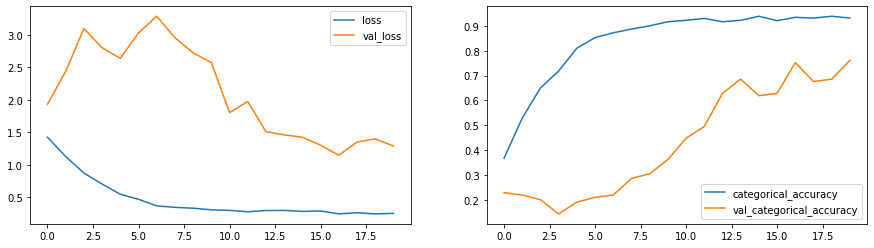

In [17]:
plot(trained_model_2)

> Observation : 
>> There is no major improvement compared to last model that is having overfitting

### Model 3 : Conv2D layers + GRU Layer+ Adam optimiser + dropout + L2 regularization¶

In [21]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(num_denselayers[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 


In [22]:
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_52 (TimeDi  (None, 15, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 15, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 15, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 dropout_10 (Dropout)        (None, 15, 30, 30, 16)    0         
                                                                 
 time_distributed_55 (TimeDi  (None, 15, 30, 30, 32)   4640      
 stributed)                                           

In [23]:
print("Total Params:", model.count_params())
trained_model_3=train_model(model)

Total Params: 152453
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_470/626052411.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 2.9325 - categorical_accuracy: 0.3659Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 3.51725, saving model to model_init_2022-05-1702_21_43.511214/model-00001-2.93248-0.36593-3.51725-0.20000.h5
45/45 [==============================] - 82s 2s/step - loss: 2.9325 - categorical_accuracy: 0.3659 - val_loss: 3.5173 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 2.3000 - categorical_accuracy: 0.5407
Epoch 00002: val_loss did not improve from 3.51725
45/45 [==============================] - 80s 2s/step - loss: 2.3000 - categorical_accuracy: 0.5407 - val_loss: 3.5812 - val_categorical_accuracy: 0.1333 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 1.9680 - categorical_accuracy: 0.5689
Epoch 00003: val_loss improved from 3.51725 to 3.32873, saving model to model_init

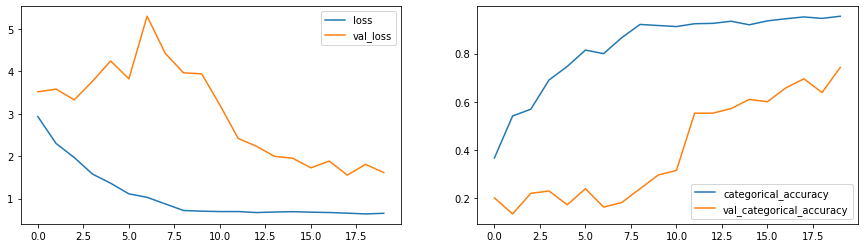

In [24]:
plot(trained_model_3)

> Observation : 
>> Val Loss is getting lower

### Model 4 : Conv2D layers + GRU Layer+ SDG optimiser + dropout + L2 regularization¶

In [25]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(num_denselayers[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

 # using Softmax as last layer
model.add(Dense(num_classes, activation='softmax'))

In [26]:
optimiser = "sgd" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_65 (TimeDi  (None, 15, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 15, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 15, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 dropout_14 (Dropout)        (None, 15, 30, 30, 16)    0         
                                                                 
 time_distributed_68 (TimeDi  (None, 15, 30, 30, 32)   4640      
 stributed)                                           

In [27]:
print("Total Params:", model.count_params())
trained_model_4=train_model(model)

Total Params: 152453
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_470/626052411.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 3.2059 - categorical_accuracy: 0.2948Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 3.33818, saving model to model_init_2022-05-1702_21_43.511214/model-00001-3.20594-0.29481-3.33818-0.20952.h5
45/45 [==============================] - 81s 2s/step - loss: 3.2059 - categorical_accuracy: 0.2948 - val_loss: 3.3382 - val_categorical_accuracy: 0.2095 - lr: 0.0100
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 2.8740 - categorical_accuracy: 0.4385
Epoch 00002: val_loss improved from 3.33818 to 3.32628, saving model to model_init_2022-05-1702_21_43.511214/model-00002-2.87395-0.43852-3.32628-0.17143.h5
45/45 [==============================] - 79s 2s/step - loss: 2.8740 - categorical_accuracy: 0.4385 - val_loss: 3.3263 - val_categorical_accuracy: 0.1714 - lr: 0.0100
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 2.7260 - catego

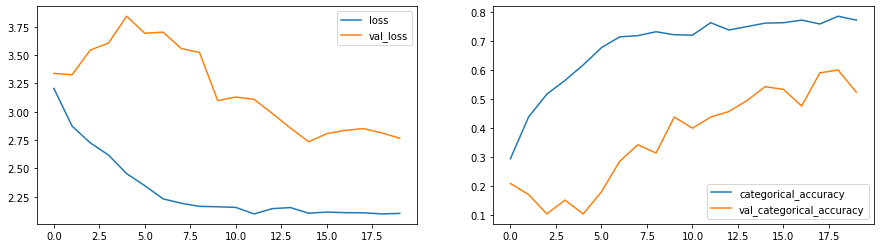

In [28]:
plot(trained_model_4)

> Observation : 
>> Increase in validation accuracy

### Model 5 : Conv3D layers + Dropout + Batch Normalization + L2 Regularization¶

In [29]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()


model.add(Conv3D(num_featuremaps[0], (3, 3, 3), padding = 'same', input_shape = input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size = (2, 2, 2)))
model.add(Dropout(0.25))
          
model.add(Conv3D(num_featuremaps[1], (2, 2, 2), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size = (2, 2, 2)))

model.add(Conv3D(num_featuremaps[2], (2, 2, 2), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size = (2, 2, 2)))
model.add(Dropout(0.25))
          
model.add(Flatten())
          
model.add(Dense(num_denselayers[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
          
model.add(Dense(num_denselayers[1], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
          

 # using Softmax as last layer
model.add(Dense(num_classes, activation='softmax'))

In [30]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 dropout_18 (Dropout)        (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)    

In [31]:
print("Total Params:", model.count_params())
trained_model_5=train_model(model)

Total Params: 946245
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_470/626052411.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 4.8475 - categorical_accuracy: 0.2859Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 5.67492, saving model to model_init_2022-05-1702_21_43.511214/model-00001-4.84749-0.28593-5.67492-0.25714.h5
45/45 [==============================] - 80s 2s/step - loss: 4.8475 - categorical_accuracy: 0.2859 - val_loss: 5.6749 - val_categorical_accuracy: 0.2571 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 3.0699 - categorical_accuracy: 0.3659
Epoch 00002: val_loss did not improve from 5.67492
45/45 [==============================] - 79s 2s/step - loss: 3.0699 - categorical_accuracy: 0.3659 - val_loss: 10.4040 - val_categorical_accuracy: 0.2286 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 2.7816 - categorical_accuracy: 0.3763
Epoch 00003: val_loss did not improve from 5.67492
45/45 [=======================

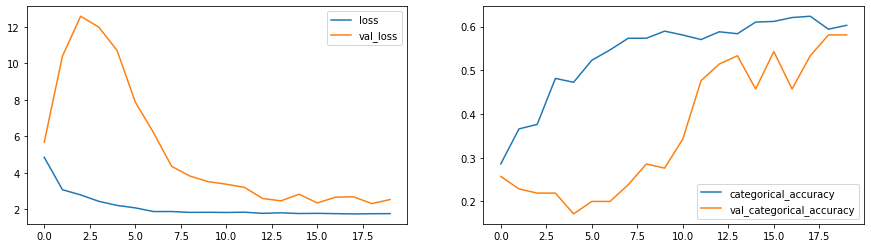

In [32]:
plot(trained_model_5)

> Observation : 
>> Good Performance, val_loss & train loss are almost same at the end
>> As well val_accuracy & train accuracy also touching eaching other at the end in the graph

### Model 6 : Transfer Learning + Resnet50 + dropout + GRU Layer¶

In [38]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [39]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model

resnet_model = ResNet50(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(resnet_model,input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))


model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1], activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 


94781440/94765736 [==============================] - 2s 0us/step


In [40]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_78 (TimeDi  (None, 15, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_79 (TimeDi  (None, 15, 4, 4, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 15, 2, 2, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 15, 8192)         0         
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 64)               

In [41]:
print("Total Params:", model.count_params())
trained_model_6=train_model(model)

Total Params: 25183685
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_470/626052411.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.3346 - categorical_accuracy: 0.4548Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 2.15663, saving model to model_init_2022-05-1702_21_43.511214/model-00001-1.33459-0.45481-2.15663-0.17143.h5


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


45/45 [==============================] - 93s 2s/step - loss: 1.3346 - categorical_accuracy: 0.4548 - val_loss: 2.1566 - val_categorical_accuracy: 0.1714 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 1.2295 - categorical_accuracy: 0.5259
Epoch 00002: val_loss did not improve from 2.15663
45/45 [==============================] - 81s 2s/step - loss: 1.2295 - categorical_accuracy: 0.5259 - val_loss: 2.3419 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.9017 - categorical_accuracy: 0.6504
Epoch 00003: val_loss improved from 2.15663 to 1.82707, saving model to model_init_2022-05-1702_21_43.511214/model-00003-0.90171-0.65037-1.82707-0.25714.h5
45/45 [==============================] - 81s 2s/step - loss: 0.9017 - categorical_accuracy: 0.6504 - val_loss: 1.8271 - val_categorical_accuracy: 0.2571 - lr: 0.0010
Epoch 4/20
45/45 [==============================] - ETA: 0s - loss: 1.0818 - catego

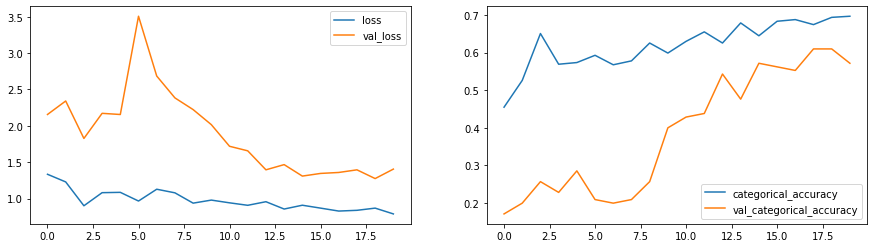

In [42]:
plot(trained_model_6)

> Observation : 
>> Degraded the performance compared to last model

### Model 7 : Transfer Learning + VGGNET + dropout + GRU Layer¶

In [43]:
from keras.applications.vgg16 import VGG16


In [44]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model
vgg_model = VGG16(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(vgg_model,input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))


model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1], activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

58900480/58889256 [==============================] - 1s 0us/step


In [45]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_82 (TimeDi  (None, 15, 3, 3, 512)    14714688  
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 15, 3, 3, 512)    2048      
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 15, 1, 1, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_85 (TimeDi  (None, 15, 512)          0         
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 64)               

In [46]:
print("Total Params:", model.count_params())
trained_model_7=train_model(model)

Total Params: 14829957
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_470/626052411.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.6120 - categorical_accuracy: 0.2548Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 2.27720, saving model to model_init_2022-05-1702_21_43.511214/model-00001-1.61199-0.25481-2.27720-0.23810.h5
45/45 [==============================] - 85s 2s/step - loss: 1.6120 - categorical_accuracy: 0.2548 - val_loss: 2.2772 - val_categorical_accuracy: 0.2381 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 1.4969 - categorical_accuracy: 0.3244
Epoch 00002: val_loss improved from 2.27720 to 2.25706, saving model to model_init_2022-05-1702_21_43.511214/model-00002-1.49692-0.32444-2.25706-0.29524.h5
45/45 [==============================] - 80s 2s/step - loss: 1.4969 - categorical_accuracy: 0.3244 - val_loss: 2.2571 - val_categorical_accuracy: 0.2952 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 1.4068 - catego

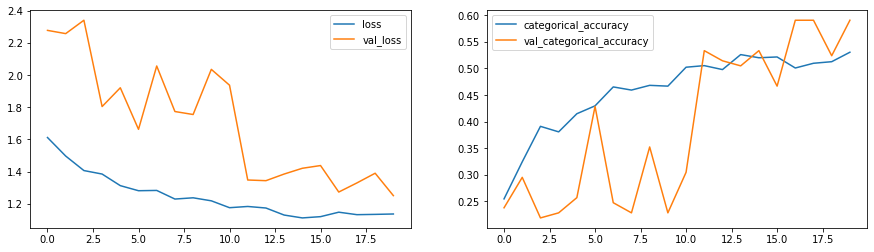

In [47]:
plot(trained_model_7)

> Observation : 
>> Val_accuracy is more than train accuracy, and train / val loss is close enough at the end

### Model 8 : Transfer Learning + mobilenet + dropout + GRU Layer¶

In [11]:
from keras.applications import  mobilenet


In [24]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25


# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

In [25]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)               

In [26]:
print("Total Params:", model.count_params())
trained_model_8=train_model(model)

Total Params: 3444485
Source path =  /home/datasets/Project_data/train ; batch size = 25


/tmp/ipykernel_423/626052411.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.2717 - categorical_accuracy: 0.5304Source path =  /home/datasets/Project_data/val ; batch size = 25

Epoch 00001: val_loss improved from inf to 1.25925, saving model to model_init_2022-05-1708_04_53.791028/model-00001-1.27168-0.53037-1.25925-0.45000.h5
27/27 [==============================] - 84s 3s/step - loss: 1.2717 - categorical_accuracy: 0.5304 - val_loss: 1.2592 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.5401 - categorical_accuracy: 0.8133
Epoch 00002: val_loss improved from 1.25925 to 0.77576, saving model to model_init_2022-05-1708_04_53.791028/model-00002-0.54007-0.81333-0.77576-0.73000.h5
27/27 [==============================] - 78s 3s/step - loss: 0.5401 - categorical_accuracy: 0.8133 - val_loss: 0.7758 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.3517 - catego

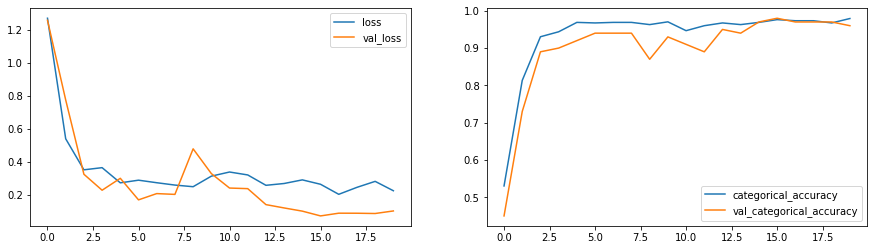

In [27]:
plot(trained_model_8)

> Observation : 
>> Awsum : Now Model start perfroming very good as both train & val accuracy is great above 90%

### Model 9 : Transfer Learning + mobilenet + dropout + GRU Layer + Increased epoch¶


In [12]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25
num_epochs = 30


# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

2022-05-18 10:44:17.877116: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-18 10:44:17.877182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [13]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 64)                2

In [14]:
print("Total Params:", model.count_params())
trained_model_9=train_model(model)

Total Params: 3444485
Source path =  /home/datasets/Project_data/train ; batch size = 15


/tmp/ipykernel_433/1512965830.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30


2022-05-18 10:44:25.725149: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 1.1981 - categorical_accuracy: 0.5363Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.08503, saving model to model_init_2022-05-1810_43_00.579574/model-00001-1.19809-0.53630-1.08503-0.66667.h5
45/45 [==============================] - 106s 2s/step - loss: 1.1981 - categorical_accuracy: 0.5363 - val_loss: 1.0850 - val_categorical_accuracy: 0.6667 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 0.4748 - categorical_accuracy: 0.8459
Epoch 00002: val_loss improved from 1.08503 to 0.97484, saving model to model_init_2022-05-1810_43_00.579574/model-00002-0.47479-0.84593-0.97484-0.80952.h5
45/45 [==============================] - 96s 2s/step - loss: 0.4748 - categorical_accuracy: 0.8459 - val_loss: 0.9748 - val_categorical_accuracy: 0.8095 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 0.3550 - categorical_accu

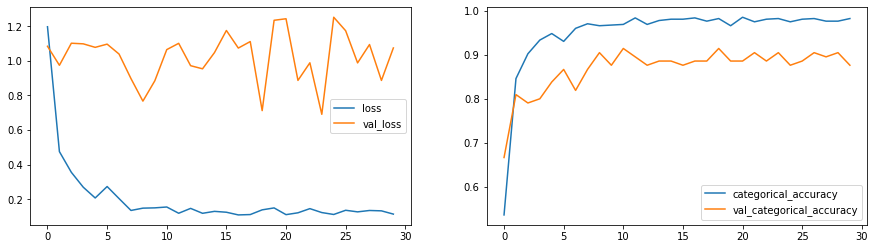

In [15]:
plot(trained_model_9)

> Observation : 
>> Degraded the Performance Compared to Last Model

### Model 10 : Transfer Learning + mobilenet + dropout + GRU Layer + Increased epoch + Increased Batch Size¶

In [16]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25
num_epochs = 30

# increasing batch Size
batch_size = 20

# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 


In [17]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 64)               

In [18]:
print("Total Params:", model.count_params())
trained_model_10=train_model(model)

Total Params: 3444485
Source path =  /home/datasets/Project_data/train ; batch size = 20


/tmp/ipykernel_433/1512965830.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.3501 - categorical_accuracy: 0.4632Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.12264, saving model to model_init_2022-05-1810_43_00.579574/model-00001-1.35009-0.46324-1.12264-0.54000.h5
34/34 [==============================] - 97s 3s/step - loss: 1.3501 - categorical_accuracy: 0.4632 - val_loss: 1.1226 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.5366 - categorical_accuracy: 0.8456
Epoch 00002: val_loss improved from 1.12264 to 0.38190, saving model to model_init_2022-05-1810_43_00.579574/model-00002-0.53661-0.84559-0.38190-0.88000.h5
34/34 [==============================] - 92s 3s/step - loss: 0.5366 - categorical_accuracy: 0.8456 - val_loss: 0.3819 - val_categorical_accuracy: 0.8800 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.2874 - catego

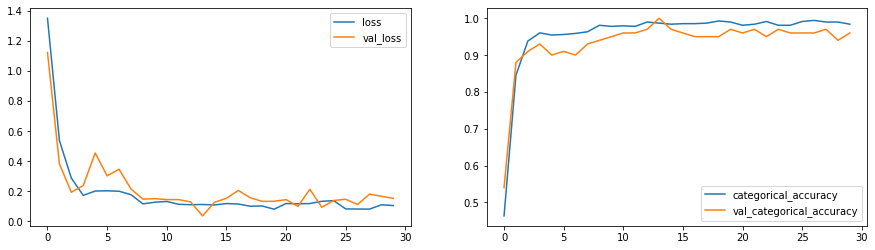

In [19]:
plot(trained_model_10)

# <b style=color:red> Selected Model ( Best Performing) </b> 

>Train Accuracy : .98  val Accuracy : .97

>Train Loss : .11057 val Loss : .12911

### Model 11 : Transfer Learning + mobilenet + dropout + GRU Layer + Increased Batch Size(More)¶

In [20]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25
num_epochs = 20

# increasing batch Size
batch_size = 25

# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 


In [21]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 64)               

In [22]:
print("Total Params:", model.count_params())
trained_model_11=train_model(model)

Total Params: 3444485
Source path =  /home/datasets/Project_data/train ; batch size = 25


/tmp/ipykernel_433/1512965830.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.2710 - categorical_accuracy: 0.5319Source path =  /home/datasets/Project_data/val ; batch size = 25

Epoch 00001: val_loss improved from inf to 1.22467, saving model to model_init_2022-05-1810_43_00.579574/model-00001-1.27103-0.53185-1.22467-0.49000.h5
27/27 [==============================] - 102s 4s/step - loss: 1.2710 - categorical_accuracy: 0.5319 - val_loss: 1.2247 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.5864 - categorical_accuracy: 0.8459
Epoch 00002: val_loss improved from 1.22467 to 0.73897, saving model to model_init_2022-05-1810_43_00.579574/model-00002-0.58635-0.84593-0.73897-0.67000.h5
27/27 [==============================] - 98s 4s/step - loss: 0.5864 - categorical_accuracy: 0.8459 - val_loss: 0.7390 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.4351 - categ

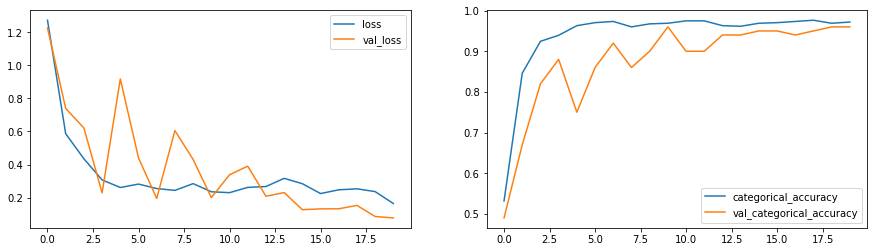

In [23]:
plot(trained_model_11)

> Observation : 
>> Almost Perfrom Like Last Model, val/ train accuracy is good no overfitting, but till now Model 8 is best

# <b style="color:red"> Neural Network Architecture development and training </b>

>•	We started by building a basic CNN+RNN model without using any dropouts. GRU was selected as it has fewer parameters than LSTM, as it lacks an output gate. 

>•	We experimented with different models by using different model configurations and hyperparameters such as introducing dropouts, using L2 regularization in combination with different optimizers.

>•	We also experimented with SGD() and Adam() optimizers but finally used Adam() as it lead to improvement in model’s accuracy. Due to the limited computational capacity we could not experiment with  other optimizers such as Adagrad and Adadelta as these take a lot of time to run.

>•	We also played around with different learning rates and ReduceLROnPlateau was used to decrease the learning rate .

>•	To overcome the issue of overfitting we used Batch Normalization, pooling and dropout layers.

>•	Then we used Conv3D and experimented with different model configurations to arrive at the final model.


# <b style="color:red"> Observations </b>

>•	The training time increased in proportion with the number of trainable parameters.

>•	A large batch size value was giving GPU Out of memory error. So we started with a batch size of 15 and gradually moved till batch size of 25. A small batch helped reducing training time but it had a trade off on model accuracy.

>•	Transfer learning boosted the overall accuracy of the model. We made use of the Resnet50 ,VGGNET and MobileNet Architecture . We took the model with MobileNet architecture as the final model due to its light weight design and high speed performance coupled with low maintenance as compared to other well-known architectures like VGG16, AlexNet, GoogleNet etc. 


# <b style="color:red"> Further suggestions for improvement: </b>

>•	Data augmentation : Exploration by building model over augmented data(flipped,rotated) could have resulted into deeper insight of the model performance.

>•	Tuning Hyperparamaters : Experimentation with different hyperparameters such as different activation functions such as , Leaky ReLU,  tanh, sigmoid, optimizers like Adagrad and Adadelta, combination of different hyperparameters like dropouts, filter size, paddings, stride length etc. can further help in boosting performance.



In [24]:
#from tensorflow import keras
#model = keras.models.load_model('model_init_2022-05-1810_43_00.579574/model-00013-0.11057-0.98971-0.12911-0.97000.h5')

In [25]:
#model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 64)               

############################################## END OF PROJECT ##############################################